# Project 5: Getting started with GenAI

## Step 1: Load in the data and preprocess it

In [17]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array


monet_path = "gan-getting-started/monet_jpg/*.jpg"
photo_path = "gan-getting-started/photo_jpg/*.jpg"

monet_files = glob(monet_path)
photo_files = glob(photo_path)

#preprocess images
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (256, 256))
    img = (tf.cast(img, tf.float32) / 127.5) - 1 
    return img

BATCH_SIZE = 16  

# ensure batches are compelte
photo_ds = (
    tf.data.Dataset.from_tensor_slices(photo_files)
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE, drop_remainder=True)  
    .shuffle(1000)
    .prefetch(tf.data.AUTOTUNE)
)

monet_ds = (
    tf.data.Dataset.from_tensor_slices(monet_files)
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE, drop_remainder=True)  
    .shuffle(1000)
    .prefetch(tf.data.AUTOTUNE)
)

train_ds = tf.data.Dataset.zip((photo_ds, monet_ds)) 



## Step 2: Create the Autoencoder to Generate Images

#### Note: An autoencoder was used due to resource constraints

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, BatchNormalization, ReLU, Add
from tensorflow.keras.models import Model

def build_improved_autoencoder():
    inputs = Input(shape=(256, 256, 3))

    #encoder
    e1 = Conv2D(64, (3, 3), strides=2, padding="same")(inputs)
    e1 = BatchNormalization()(e1)
    e1 = ReLU()(e1)

    e2 = Conv2D(128, (3, 3), strides=2, padding="same")(e1)
    e2 = BatchNormalization()(e2)
    e2 = ReLU()(e2)

    e3 = Conv2D(256, (3, 3), strides=2, padding="same")(e2)
    e3 = BatchNormalization()(e3)
    e3 = ReLU()(e3)

    e4 = Conv2D(512, (3, 3), strides=2, padding="same")(e3)  
    e4 = BatchNormalization()(e4)
    e4 = ReLU()(e4)

    #bottleneck
    b = Conv2D(512, (3, 3), padding="same")(e4)
    b = BatchNormalization()(b)
    b = ReLU()(b)

    #decoder
    d4 = Conv2DTranspose(256, (3, 3), strides=2, padding="same")(b)
    d4 = BatchNormalization()(d4)
    d4 = ReLU()(d4)
    d4 = Add()([d4, e3]) 

    d3 = Conv2DTranspose(128, (3, 3), strides=2, padding="same")(d4)
    d3 = BatchNormalization()(d3)
    d3 = ReLU()(d3)
    d3 = Add()([d3, e2])  

    d2 = Conv2DTranspose(64, (3, 3), strides=2, padding="same")(d3)
    d2 = BatchNormalization()(d2)
    d2 = ReLU()(d2)
    d2 = Add()([d2, e1]) 

    outputs = Conv2DTranspose(3, (3, 3), strides=2, padding="same", activation="tanh")(d2)

    return Model(inputs, outputs)

autoencoder = build_improved_autoencoder()
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(2e-4), loss="mae")

autoencoder.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_13 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │     73,856 │ re_lu_13[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_14 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │    295,168 │ re_lu_14[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_15 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ re_lu_15[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_16 (ReLU)     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ re_lu_16[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_17 (ReLU)     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_7  │ (None, 32, 32,    │  1,179,904 │ re_lu_17[0][0]  

 Total params: 5,468,931 (20.86 MB)

 Trainable params: 5,465,091 (20.85 MB)

 Non-trainable params: 3,840 (15.00 KB)

## Step 3: Train Autoencoder

In [20]:
EPOCHS = 10

history = autoencoder.fit(train_ds, epochs=EPOCHS)

Epoch 1/10
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1:01 4s/step - loss: 0.3947


KeyboardInterrupt



## Step 4: Test Autoencoder

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


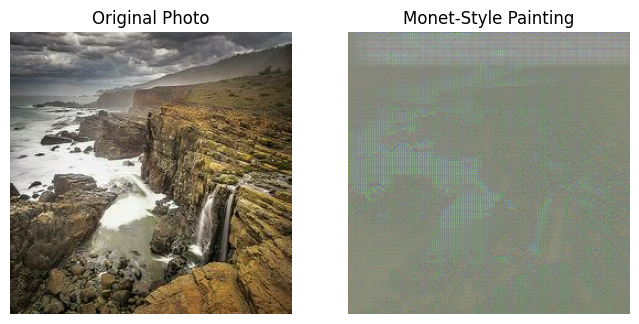

In [21]:
import matplotlib.pyplot as plt

#test photo
test_photo = preprocess_image(photo_files[0])
test_photo = tf.expand_dims(test_photo, axis=0) 

# generate
monet_painting = autoencoder.predict(test_photo)[0]


fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow((test_photo[0] + 1) / 2)  
axes[0].set_title("Original Photo")
axes[0].axis("off")

axes[1].imshow((monet_painting + 1) / 2) 
axes[1].set_title("Monet-Style Painting")
axes[1].axis("off")

plt.show()
